In [63]:
# NOTE : must be ran from the experiments folder

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

import sys

# sys.path.append('../../Libraries/GCMProject')

sys.path.append('../')
sys.path.append('../core')
sys.path.append('../../Libraries/GCMProject/')
sys.path.append('../../Libraries/')
sys.path.append('../experiments')

import core.calibration
import overlap_erm_bo
import calibration
import constants
import display
import data
import datalogging
import erm
import joint_density 
import gamp
import bo_state_evolution
import utility

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
alpha = 10.0
# noise std : corresponds to tau in the paper
sigma = 2.0
lambda_ = 0.0
# for these (alpha, sigma) want \lambda_error = 0.09761615357617182 and \lambda_loss = 0.0980462522399325

overlaps = overlap_erm_bo.get_average_theoretical_separate_overlap_reduced(alpha, lambda_, sigma, ntrials=10, code_version='gcm', d=1000)

rho, m, qbo, qerm, Q = overlaps.rho, overlaps.m, overlaps.qbo, overlaps.qerm, overlaps.Q
if np.isnan(Q):
    Q = m

In [80]:
print(overlaps)

Overlaps(rho=1.0, qbo=0.5790273813208076, mbo=nan, qerm=1.4837718808632385, m=0.9160540615933422, V=nan, Q=nan, hatqbo=nan, hatqerm=nan, hatm=nan, hatV=nan, hatQ=nan)


In [81]:
Sigma_teacher = np.array([
    [rho, m],
    [m, qerm]
])

Sigma_bo = np.array([
    [qbo, Q],
    [Q, qerm]
])

N = 100

# density of teacher is singular for sigma = 0
if sigma > 0:
    density_teacher = joint_density.get_p_one_teacher_density(Sigma_teacher, rho, N, sigma)
density_bo = joint_density.get_p_one_density(Sigma_bo, qbo, N, sigma)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21981.12it/s]


In [82]:
# theoretical calibration 
ps  = np.linspace(0., 1., N)
cal = [calibration.compute_teacher_calibration(p, rho, qerm, m, sigma) for p in ps]

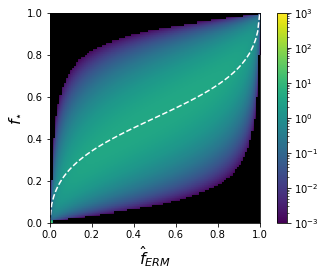

In [83]:
# FOR THE TEACHER

density_teacher[0, 0] = np.max(density_bo)

# transpose => ERM will be on column i.e x-axis
display.plot_from_density(density_teacher.T, colorbar=False, mask_vmin=1e-3, mask_vmax=1e3)
plt.plot(ps, ps - cal, 'w--')
plt.xlabel('$\\hat{f}_{ERM}$', fontsize=16)
plt.ylabel('$f_{\\star}$', fontsize=16)
plt.colorbar()
plt.clim(1e-3, 1e3)
plt.gcf().subplots_adjust(bottom=0.15)

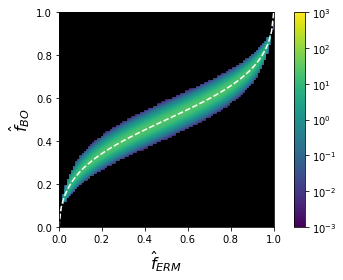

In [84]:
# FOR THE BAYES - ERM

# transpose => ERM will be on column i.e x-axis
display.plot_from_density(density_bo.T, colorbar=False, mask_vmin=1e-3, mask_vmax=1e3)
plt.xlabel('$\hat{f}_{ERM}$', fontsize=16)
plt.ylabel('$\hat{f}_{BO}$', fontsize=16)

ps  = np.linspace(0., 1., N)
cal = [calibration.compute_bo_calibration(p, qbo, qerm, Q, sigma) for p in ps]

plt.plot(ps, ps - cal, 'w--')

plt.clim(1e-3, 1e3)
cbar = plt.colorbar()
cbar.ax.minorticks_off()
plt.gcf().subplots_adjust(bottom=0.15)

plt.tight_layout()

### Experimental estimation of the density

In [ ]:
def experimental_density(alpha, sigma, lambda_, ntest):
    d = 300
    wstar, X, Y = data.sample_instance(d, alpha, 'probit', sig = sigma)

    # get estimator from ERM
    werm = erm.erm_logistic_regression(X, Y, lambda_)

    # get estimator from AMP
    res_gamp = gamp.iterate_gamp(X, Y, wstar, sig = sigma, verbose=False)
    what, vhat = res_gamp['estimator'], res_gamp['variances']

    # SAMPLE TEST SET
    erm_probas, bo_probas, teacher_probas = [], [], []
    batchsize = 1000
    nbatch = ntest // batchsize
    for batch in range(nbatch):
        Xtest, Ytest = data.sample_data_n(wstar, batchsize, 'probit', sig = sigma)
        bo_probas += [utility.y_bo_proba(what, vhat, x, 1, sigma) for x in Xtest] 
        teacher_probas += [utility.y_teacher_proba(wstar, x, 1.0, sigma) for x in Xtest]
        erm_probas += [utility.sigmoid(werm @ x) for x in Xtest]

    # PLOT THE CALIBRATION
    n_ps         = 40
    dp           = 1. / n_ps
    bins         = [i*dp for i in range(n_ps)] + [1.]
    teacher_mean = [0]*n_ps
    bo_mean      = [0]*n_ps
    for k in range(n_ps):
        indexes = [l for l in range(ntest) if bins[k] < erm_probas[l] <= bins[k+1]]
        teacher_mean[k] = np.mean([teacher_probas[l] for l in indexes])
        bo_mean[k] = np.mean([bo_probas[l] for l in indexes])

    # histogram
    ax = plt.gca()
    ax.set_facecolor((0., 0., 0.))

    hist = plt.hist2d(erm_probas, teacher_probas, bins=n_ps, density=True, norm=mpl.colors.LogNorm())
    plt.plot(np.linspace(0., 1., n_ps), teacher_mean)
    ax.set_aspect('equal', adjustable='box')
    plt.clim(1e-3, 1e3)
    plt.xlabel('$\hat{f}_{ERM}$', fontsize=16)
    plt.ylabel('$f_{\star}$', fontsize=16)

    cbar = plt.colorbar()
    cbar.ax.minorticks_off()
    plt.show()
    
    # === 
    
    ax = plt.gca()
    ax.set_facecolor((0., 0., 0.))
    hist, _, _, im = plt.hist2d(erm_probas, bo_probas, bins=n_ps, density=True, norm=mpl.colors.LogNorm())
    plt.plot(np.linspace(0., 1., n_ps), teacher_mean)
    ax.set_aspect('equal', adjustable='box')
    plt.clim(1e-3, 1e3)
    plt.xlabel('$\hat{f}_{ERM}$', fontsize=16)
    plt.ylabel('$\hat{f}_{BO}$', fontsize=16)
    cbar = plt.colorbar()
    cbar.ax.minorticks_off()
    
    plt.show()

#     plt.show()

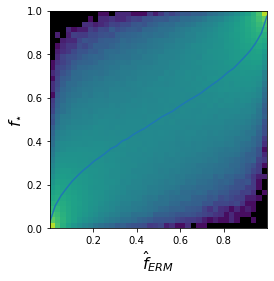

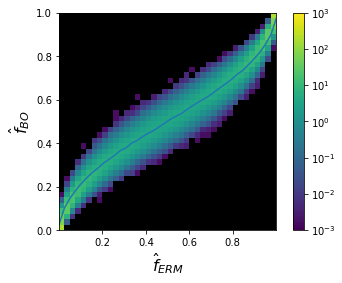

In [35]:
experimental_density(alpha, sigma, lambda_, 1000000)